# IEOR 242 Assignment 10
Classify MDA sections of 10-K reports with various methods.

In [1]:
import pandas as pd
import numpy as np
import pickle
import gc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.classify import MaxentClassifier

from classifier_evaluation import evaluate_classifier, show_most_informative_features
from clean_helper import stem_words

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
import pymysql
from sqlalchemy import create_engine

# Connect to team database
engine = create_engine('mysql+pymysql://<user>:<password>@<host>[:<port>]/<dbname>')

In [3]:
# Standard number of features
MAX_FEATURES = 1000

# Path to the Pickle file
PICKLE_FILE = 'prepared_reports_final.pickle'

# Path to the Loughran McDonald dictionary
MASTER_DICT_PATH = '../lecture/LoughranMcDonald_MasterDictionary_2014.xlsx'

## Data Loading
Read the dataframe with file contents and labels from a Pickle file.

In [4]:
with open(PICKLE_FILE, 'rb') as f:
    class_df = pickle.load(f)

print('Number of reports: %d' % len(class_df))
class_df.head()

Number of reports: 12504


,content,cik,year,quarter,subsector,name,tic,SALES_value,OIADP,AT,CEQ,SALES,OIADP_change,AT_change,CEQ_change,SALES_change
0,Item Management s Discussion and Analysis of ...,855654.0,2012.0,3.0,35201010.0,IMMUNOGEN INC,IMGN,3.252,pos,neg,neg,neg,19.30809539,-5.710814,-16.88298821,-9.225092251
1,The following discussion and analysis provide...,788920.0,2011.0,3.0,35101010.0,PRO-DEX INC/CO,PDEX,6.876,neg,pos,pos,neg,-14.5187602,14.640276,11.23801315,-1.89063409
2,Item Managements Discussion and Analysis of...,70487.0,2008.0,1.0,NaN,None,None,13.454,neg,pos,pos,neg,-22.56208359,0.525303,2.764397345,-11.54303553
3,BEGIN PRIVACY ENHANCED MESSAGE Proc ...,1027915.0,1999.0,2.0,NaN,None,None,7.873,neg,neg,pos,neg,-814.6341463,-56.183942,15.27777778,-65.41343833
4,Item Management s Discussion and Analy...,749660.0,2003.0,1.0,NaN,None,None,2.214,pos,neg,neg,neg,328.5234899,-1.733328,-5.815035355,-39.56639566


In [5]:
# Reduce data set for faster model development
class_df = class_df.sample(frac=0.3).reset_index(drop=True)
print('Number of reports: %d' % len(class_df))

Number of reports: 3751


In [6]:
# Replace subsector codes with subsector names
subsector_list = ['Biotechnology', 'Health Care Equipment', 'Pharmaceuticals', 'Health Care Services',
                  'Health Care Supplies', 'Life Sciences Tools & Services', 'Health Care Technology',
                  'Health Care Facilities', 'Health Care Distributors', 'Managed Health Care']
class_df['Subsector Name'] = np.nan
class_df['Subsector Name'].categories = subsector_list
class_df.loc[class_df['subsector'] == 35201010.0, 'Subsector Name'] = 'Biotechnology'
class_df.loc[class_df['subsector'] == 35101010.0, 'Subsector Name'] = 'Health Care Equipment'
class_df.loc[class_df['subsector'] == 35202010.0, 'Subsector Name'] = 'Pharmaceuticals'
class_df.loc[class_df['subsector'] == 35102015.0, 'Subsector Name'] = 'Health Care Services'
class_df.loc[class_df['subsector'] == 35101020.0, 'Subsector Name'] = 'Health Care Supplies'
class_df.loc[class_df['subsector'] == 35203010.0, 'Subsector Name'] = 'Life Sciences Tools & Services'
class_df.loc[class_df['subsector'] == 35103010.0, 'Subsector Name'] = 'Health Care Technology'
class_df.loc[class_df['subsector'] == 35102020.0, 'Subsector Name'] = 'Health Care Facilities'
class_df.loc[class_df['subsector'] == 35102010.0, 'Subsector Name'] = 'Health Care Distributors'
class_df.loc[class_df['subsector'] == 35102030.0, 'Subsector Name'] = 'Managed Health Care'
class_df.head()

,content,cik,year,quarter,subsector,name,tic,SALES_value,OIADP,AT,CEQ,SALES,OIADP_change,AT_change,CEQ_change,SALES_change,Subsector Name
0,BEGIN PRIVACY ENHANCED MESSAGE Proc ...,891933.0,1998.0,1.0,NaN,None,None,0.875,pos,neg,pos,neg,11.00581248,-27.944530,221.3811421,-2.857142857,NaN
1,Item Managements Discussion and Analysis ...,880643.0,2006.0,1.0,NaN,None,None,0.067,pos,pos,neg,pos,47.68094535,91.649018,-31.05743327,465.6716418,NaN
2,Item Management s Discussion and Analysis of ...,1063665.0,2013.0,3.0,35101010.0,CORGENIX MEDICAL CORP,CONX,2.496,neg,pos,pos,neg,-146.2686567,3.660031,0.837053571,-4.126602564,Health Care Equipment
3,ITEM MANAGEMENT S DISCUSSION AND ANALYSIS ...,887757.0,2001.0,2.0,NaN,None,None,14.835,neg,neg,neg,neg,-45.92178771,-6.520805,-9.097918273,-3.707448601,NaN
4,ITEM MANAGEMENTS DISCUSSION AND ANAL...,1097136.0,2009.0,1.0,NaN,None,None,12.877,neg,pos,pos,pos,-108.4552846,0.031059,0.192527096,4.853614972,NaN


## Feature Building

In [7]:
# Bag of Words
count_vec = CountVectorizer(analyzer='word', stop_words='english', max_features=MAX_FEATURES)
# Bag of Words with reduced number of features
count_vec_red_feat = CountVectorizer(analyzer='word', stop_words='english', max_features=100)
# Bag of Words with 2-grams
count_vec_2grams = CountVectorizer(analyzer='word', ngram_range=(1, 2), max_features=MAX_FEATURES)
# tf-idf
tfidf_vec = TfidfVectorizer(analyzer='word', stop_words='english', max_features=MAX_FEATURES)
# tf-idf with reduced number of features
tfidf_vec_red_feat = TfidfVectorizer(analyzer='word', stop_words='english', max_features=100)
# tf-idf with 2-grams
tfidf_vec_2grams = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), max_features=MAX_FEATURES)

## Calculate Sentiment with Finance Dictionary
Loughran-McDonalds dictionary source: http://www3.nd.edu/~mcdonald/Word_Lists.html

In [8]:
# Create vectorizer to calculate word count
count_matrix = count_vec.fit_transform(class_df['content'])
feature_names = count_vec.get_feature_names()
count_df = pd.DataFrame(count_matrix.toarray())
count_df.columns = [i.upper() for i in feature_names]
count_df.head()

,ABILITY,ABLE,ACCEPTANCE,ACCEPTED,ACCESS,ACCOMPANYING,ACCORDANCE,ACCORDINGLY,ACCOUNT,ACCOUNTED,...,WIDTH,WORK,WORKING,WORLDWIDE,WRITE,WRITING,WRITTEN,YEAR,YEARS,YORK
0,13,14,9,7,17,7,15,3,1,3,...,0,7,6,3,0,6,23,59,35,4
1,3,1,1,2,1,0,2,2,1,2,...,0,1,1,0,2,0,0,10,7,0
2,2,1,1,1,1,3,5,2,0,0,...,1,1,4,0,0,0,0,33,7,3
3,0,0,0,0,1,0,0,0,0,0,...,0,1,10,0,3,0,0,8,4,0
4,3,3,0,2,0,1,5,3,7,4,...,0,0,9,0,4,0,0,17,13,0


In [9]:
# Loading the dictionary
dict = pd.read_excel(MASTER_DICT_PATH)

# Create a smaller dictionary that only contains the words which are used in the reports
minidict = dict[dict['Word'].isin(count_df.columns)]
minidict = minidict.set_index('Word')

# Clean the positive & negative columns
minidict.loc[minidict['Positive'] > 0, 'Positive'] = 1
minidict.loc[minidict['Negative'] > 0, 'Negative'] = -1
minidict.head()

,Sequence Number,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Constraining,Superfluous,Interesting,Modal,Irr_Verb,Harvard_IV,Syllables,Source
Word,,,,,,,,,,,,,,,,,,
ABILITY,101,8083865,0.000568,0.000600,0.000541,754403,0,0,0,0,0,0,0,0,0,0,4,12of12inf
ABLE,126,3253260,0.000229,0.000232,0.000343,553588,0,1,0,0,0,0,0,0,0,0,2,12of12inf
ACCEPTANCE,408,1398783,0.000098,0.000076,0.000181,310255,0,0,0,0,0,0,0,0,0,0,3,12of12inf
ACCEPTED,412,4093060,0.000288,0.000434,0.000434,802933,0,0,0,0,0,0,0,0,0,0,3,12of12inf
ACCESS,416,2312440,0.000162,0.000132,0.000750,407688,0,0,0,0,0,0,0,0,0,0,2,12of12inf


In [10]:
# Just some transformations to facilitate merging
count_df = count_df.T 
count_df.index.name = 'Word'

# Merge the dictionary with the report dataframe
senti_df = pd.merge(count_df, minidict, how='inner', left_index=True, right_index=True)
print('Number of rows: %d' % len(senti_df))
senti_df.head()

Number of rows: 962


,0,1,2,3,4,5,6,7,8,9,...,Uncertainty,Litigious,Constraining,Superfluous,Interesting,Modal,Irr_Verb,Harvard_IV,Syllables,Source
Word,,,,,,,,,,,,,,,,,,,,,
ABILITY,13,3,2,0,3,0,7,7,2,2,...,0,0,0,0,0,0,0,0,4,12of12inf
ABLE,14,1,1,0,3,1,0,1,1,0,...,0,0,0,0,0,0,0,0,2,12of12inf
ACCEPTANCE,9,1,1,0,0,0,2,0,2,0,...,0,0,0,0,0,0,0,0,3,12of12inf
ACCEPTED,7,2,1,0,2,3,1,4,2,1,...,0,0,0,0,0,0,0,0,3,12of12inf
ACCESS,17,1,1,1,0,0,0,3,2,0,...,0,0,0,0,0,0,0,0,2,12of12inf


In [11]:
# Calculate sentiments for each report and add it to the classification and report dataframe
for i, row in class_df.iterrows():
    class_df.loc[i, 'senti_pos'] = sum(senti_df[i] * senti_df['Positive'])
    class_df.loc[i, 'senti_neg'] = sum(senti_df[i] * senti_df['Negative'])
    class_df.loc[i, 'pos_word_count'] = sum(senti_df.loc[senti_df[i] > 1, 'Positive'])
    class_df.loc[i, 'neg_word_count'] = sum(senti_df.loc[senti_df[i] > 1, 'Negative'])
class_df.head()

,content,cik,year,quarter,subsector,name,tic,SALES_value,OIADP,AT,...,SALES,OIADP_change,AT_change,CEQ_change,SALES_change,Subsector Name,senti_pos,senti_neg,pos_word_count,neg_word_count
0,BEGIN PRIVACY ENHANCED MESSAGE Proc ...,891933.0,1998.0,1.0,NaN,None,None,0.875,pos,neg,...,neg,11.00581248,-27.944530,221.3811421,-2.857142857,NaN,164.0,-249.0,15.0,-20.0
1,Item Managements Discussion and Analysis ...,880643.0,2006.0,1.0,NaN,None,None,0.067,pos,pos,...,pos,47.68094535,91.649018,-31.05743327,465.6716418,NaN,47.0,-59.0,6.0,-8.0
2,Item Management s Discussion and Analysis of ...,1063665.0,2013.0,3.0,35101010.0,CORGENIX MEDICAL CORP,CONX,2.496,neg,pos,...,neg,-146.2686567,3.660031,0.837053571,-4.126602564,Health Care Equipment,7.0,-22.0,1.0,-6.0
3,ITEM MANAGEMENT S DISCUSSION AND ANALYSIS ...,887757.0,2001.0,2.0,NaN,None,None,14.835,neg,neg,...,neg,-45.92178771,-6.520805,-9.097918273,-3.707448601,NaN,2.0,-26.0,0.0,-4.0
4,ITEM MANAGEMENTS DISCUSSION AND ANAL...,1097136.0,2009.0,1.0,NaN,None,None,12.877,neg,pos,...,pos,-108.4552846,0.031059,0.192527096,4.853614972,NaN,23.0,-51.0,6.0,-10.0


## Classifier Evaluation

### tf-idf

In [12]:
sales_df = class_df.loc[(class_df['SALES'] == 'pos') | (class_df['SALES'] == 'neg')]

tfidf_matrix = tfidf_vec.fit_transform(sales_df['content'])

tfidf_eval = evaluate_classifier(MultinomialNB(fit_prior=False), tfidf_matrix, sales_df['SALES'], 5)
tfidf_eval[1]

{'Accuracy': 0.61295417625737447,
 'F1 Score': 0.69002627589349341,
 'Precision': 0.72486111381795182,
 'Recall': 0.65838607696619911}

### tf-idf with Stemming

In [13]:
sales_df_stemmed = sales_df
sales_df_stemmed['content'] = sales_df_stemmed['content'].map(lambda c: stem_words(c)).tolist()

tfidf_matrix = tfidf_vec.fit_transform(sales_df['content'])

tfidf_eval = evaluate_classifier(MultinomialNB(fit_prior=False), tfidf_matrix, sales_df_stemmed['SALES'], 5)
tfidf_eval[1]

/home/stefan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


{'Accuracy': 0.61312589410713725,
 'F1 Score': 0.69020903314615656,
 'Precision': 0.72497159274907719,
 'Recall': 0.65862777367769254}

### Bag of Words

In [14]:
count_matrix = count_vec.fit_transform(sales_df['content'])

count_eval = evaluate_classifier(MultinomialNB(fit_prior=False), count_matrix, sales_df['SALES'], 5)
count_eval[1]

{'Accuracy': 0.40493676737236123,
 'F1 Score': 0.20437403154463935,
 'Precision': 0.81606354810238302,
 'Recall': 0.1168181971896127}

In [15]:
show_most_informative_features(count_vec, count_eval[0])

{'least': [(-3.9082315735101805, 'company'),
  (-4.2310769677358735, 'million'),
  (-4.6935187918469889, 'stock'),
  (-4.7251291098995551, 'shall'),
  (-4.7861567968914613, 'december'),
  (-4.798258491938288, 'year'),
  (-4.9232021318223218, 'net'),
  (-4.9271669279487629, 'agreement'),
  (-4.9802726314336123, 'financial'),
  (-5.0392152483818951, 'cash')],
 'most': [(-8.399411937747141, 'debentures'),
  (-8.3612081103353706, 'cell'),
  (-8.3442838636712846, 'calendar'),
  (-8.3231207752849681, 'trading'),
  (-8.3093627595236708, 'milestones'),
  (-8.3020807897167508, 'successfully'),
  (-8.2957914608091876, 'organizations'),
  (-8.282401878862645, 'real'),
  (-8.2710223926967785, 'therapeutic'),
  (-8.2670547390864844, 'scientific')]}

### Most Informative Features per Subsector

In [16]:
for subsector in subsector_list:
    print(subsector)
    subsector_df = sales_df[(sales_df['Subsector Name'] == subsector)]
    if(len(subsector_df) > 10):
        count_matrix = count_vec.fit_transform(subsector_df['content'])
        count_eval = evaluate_classifier(MultinomialNB(fit_prior=False), count_matrix, subsector_df['SALES'], 5)
        print(list(map(lambda x: x[1], show_most_informative_features(count_vec, count_eval[0])['most'])))

Biotechnology
['arabic', 'pageno', 'zem', 'janssen', 'class', 'xiaflex', 'discontinued', 'injection', 'mr', 'hold']
Health Care Equipment
['eecp', 'heart', 'series', 'competitors', 'diagnostics', 'skin', 'adequate', 'therapy', 'pulse', 'class']
Pharmaceuticals
['gralise', 'pgp', 'king', 'glumetza', 'oxford', 'tagged', 'widths', 'ars', 'column', 'shipped']
Health Care Services
['dca', 'mevion', 'neurometric', 'fda', 'series', 'advertising', 'reports', 'psn', 'client', 'promotional']
Health Care Supplies
['icl', 'iol', 'staar', 'staars', 'silicone', 'hydrogel', 'lenses', 'contact', 'influenza', 'bsc']
Life Sciences Tools & Services
['agilent', 'preclinical', 'orders', 'partners', 'care', 'implemented', 'percent', 'point', 'infrastructure', 'measures']
Health Care Technology
['extinguishment', 'gaming', 'medicsight', 'mgt', 'pathologists', 'technest', 'talent', 'accuro', 'preferred', 'patent']
Health Care Facilities
['vision', 'hca', 'equivalent', 'emergency', 'admission', 'auction', 'cal

### Test Multiple Labels & Classifiers

In [17]:
# Store F1 values for multiple labels
f1_score_df = pd.DataFrame()
f1_score_df.columns.name = 'Label'
f1_score_df.index.name = 'Classifier'

# Store accuracy for multiple labels
acc_score_df = pd.DataFrame()
acc_score_df.columns.name = 'Label'
acc_score_df.index.name = 'Classifier'

# List vectorizations to evaluate 
vecs = { 'BoW': count_vec, 'BoW Reduced': count_vec_red_feat,
         'BoW 2-grams': count_vec_2grams, 'tf-idf': tfidf_vec,
         'tf-idf Reduced': tfidf_vec_red_feat, 'tf-idf 2-grams': tfidf_vec_2grams }

# Prepare classifier
classifier = MultinomialNB(fit_prior=False)

In [18]:
# Calculate every vectorization and label combination
for label in ['OIADP', 'SALES', 'AT', 'CEQ']:
    for vec_name, vec in vecs.items():
        print('Classifying %s with %s' % (label, vec_name))
        # Build matrix with reports and features
        sub_df = class_df.loc[(class_df[label] == 'pos') | (class_df[label] == 'neg')]
        matrix = vec.fit_transform(sub_df['content'])
        
        # Train and evaulate classifier
        metrics = evaluate_classifier(classifier, matrix, sub_df[label], 5)[1]
        acc_score_df.loc[vec_name, label] = metrics['Accuracy']
        f1_score_df.loc[vec_name, label] = metrics['F1 Score']

        # Free up memory
        sub_df = None
        matrix = None
        gc.collect()
        
    # Perform tf-idf with stemming
    vec_name = 'tf-idf Stemming'
    print('Classifying %s with %s' % (label, vec_name))
    sub_df = class_df.loc[(class_df[label] == 'pos') | (class_df[label] == 'neg')]
    matrix = vec.fit_transform(sub_df['content'].map(lambda c: stem_words(c)).tolist())
    metrics = evaluate_classifier(classifier, matrix, sub_df[label], 5)[1]
    acc_score_df.loc[vec_name, label] = metrics['Accuracy']
    f1_score_df.loc[vec_name, label] = metrics['F1 Score']
    
    # Perform maximum entropy classifier
    

Classifying OIADP with BoW Reduced
Classifying OIADP with tf-idf Reduced
Classifying OIADP with tf-idf 2-grams
Classifying OIADP with BoW
Classifying OIADP with tf-idf
Classifying OIADP with BoW 2-grams
Classifying OIADP with tf-idf Stemming
Classifying SALES with BoW Reduced
Classifying SALES with tf-idf Reduced
Classifying SALES with tf-idf 2-grams
Classifying SALES with BoW
Classifying SALES with tf-idf
Classifying SALES with BoW 2-grams
Classifying SALES with tf-idf Stemming
Classifying AT with BoW Reduced
Classifying AT with tf-idf Reduced
Classifying AT with tf-idf 2-grams
Classifying AT with BoW
Classifying AT with tf-idf
Classifying AT with BoW 2-grams
Classifying AT with tf-idf Stemming
Classifying CEQ with BoW Reduced
Classifying CEQ with tf-idf Reduced
Classifying CEQ with tf-idf 2-grams
Classifying CEQ with BoW
Classifying CEQ with tf-idf
Classifying CEQ with BoW 2-grams
Classifying CEQ with tf-idf Stemming


In [19]:
# Write data back to database
# acc_score_df.to_sql('result_f1_score_matrix', engine, if_exists='replace')
# f1_score_df.to_sql('result_f1_score_matrix', engine, if_exists='replace')

In [20]:
acc_score_df.sort_index(inplace=True)
acc_score_df

Label,OIADP,SALES,AT,CEQ
Classifier,,,,
BoW,0.468696,0.404948,0.598825,0.632189
BoW 2-grams,0.466220,0.384403,0.575370,0.621486
BoW Reduced,0.500248,0.404080,0.608986,0.632727
tf-idf,0.563133,0.613110,0.624150,0.664942
tf-idf 2-grams,0.558311,0.593641,0.615410,0.662854
tf-idf Reduced,0.552221,0.594710,0.616227,0.663495
tf-idf Stemming,0.466489,0.384799,0.575240,0.621024


In [21]:
f1_score_df.sort_index(inplace=True)
f1_score_df

Label,OIADP,SALES,AT,CEQ
Classifier,,,,
BoW,0.086914,0.204728,0.468741,0.613241
BoW 2-grams,0.066853,0.134789,0.336875,0.588285
BoW Reduced,0.273130,0.221375,0.549455,0.629052
tf-idf,0.580874,0.690151,0.635865,0.697900
tf-idf 2-grams,0.552841,0.667866,0.615326,0.690775
tf-idf Reduced,0.558769,0.672135,0.632354,0.698804
tf-idf Stemming,0.068832,0.134836,0.336338,0.587467


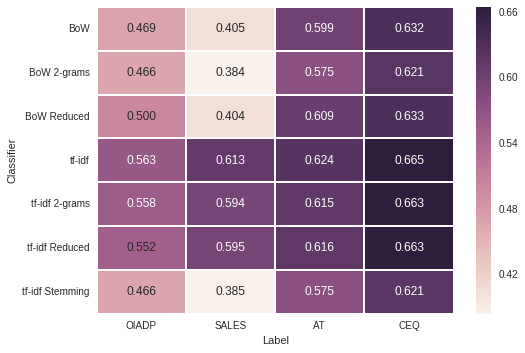

In [22]:
# Plot heat map for accuracy
sns.heatmap(acc_score_df, annot=True, fmt='.3f', linewidths=1)

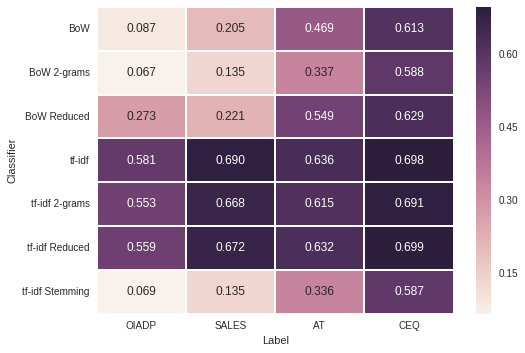

In [23]:
# Plot heat map for F1 Score
sns.heatmap(f1_score_df, annot=True, fmt='.3f', linewidths=1)

### Bag of Words - Optimize Number of Features

In [24]:
eval_df = pd.DataFrame(columns=['Max Feature'])

classifier = MultinomialNB(fit_prior=False)

for i in [10, 50, 100, 500, 1000, 5000, 10000]:
    print('Classifying with %d features.' % i)
    tfidf_vec = TfidfVectorizer(analyzer='word', stop_words='english', max_features=i)
    tfidf_matrix = tfidf_vec.fit_transform(sales_df['content'])
    tfidf_eval = evaluate_classifier(classifier, tfidf_matrix, sales_df['SALES'], 5)
    result = pd.DataFrame(tfidf_eval[1], index=[0])
    result['Max Feature'] = i
    eval_df = eval_df.append(result)

eval_df

Classifying with 10 features.
Classifying with 50 features.
Classifying with 100 features.
Classifying with 500 features.
Classifying with 1000 features.
Classifying with 5000 features.
Classifying with 10000 features.


,Accuracy,F1 Score,Max Feature,Precision,Recall
0,0.562687,0.639234,10.0,0.694347,0.592226
0,0.597932,0.674068,50.0,0.717649,0.635478
0,0.594557,0.671848,100.0,0.714166,0.634265
0,0.605552,0.681166,500.0,0.723056,0.643864
0,0.613161,0.690249,1000.0,0.724900,0.658760
0,0.681904,0.767602,5000.0,0.735393,0.802763
0,0.716984,0.816805,10000.0,0.708336,0.964500


In [25]:
# Write data back to database
# eval_df.to_sql('result_max_feature_eval', engine, if_exists='replace')

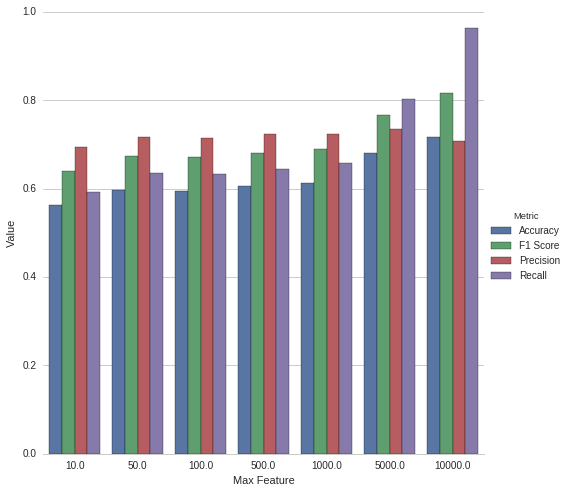

In [26]:
bar_chart_prep = pd.melt(eval_df, id_vars=['Max Feature'],
                         value_vars=['Accuracy', 'F1 Score', 'Precision', 'Recall'],
                         var_name='Metric', value_name='Value')

g = sns.factorplot(x='Max Feature', y='Value', hue='Metric', data=bar_chart_prep, size=7, kind='bar')
g.despine(left=True)
g.set_ylabels('Value')

### Bag of Words - Optimize n-grams

In [27]:
ngram_eval_df = pd.DataFrame(columns=['n'])

classifier = MultinomialNB(fit_prior=False)

for n in [1, 2, 3]:
    print('Classifying with (1,%d)-grams.' % n)
    tfidf_vec = TfidfVectorizer(analyzer='word', max_features=MAX_FEATURES, ngram_range=(1,n))
    tfidf_matrix = tfidf_vec.fit_transform(sales_df['content'])
    result = pd.DataFrame(evaluate_classifier(classifier, tfidf_matrix, sales_df['SALES'], 5)[1], index=[0])
    result['n'] = n
    ngram_eval_df = ngram_eval_df.append(result)

    # Free up memory
    tfidf_vec = None
    tfidf_matrix = None
    gc.collect()

ngram_eval_df

Classifying with (1,1)-grams.
Classifying with (1,2)-grams.
Classifying with (1,3)-grams.


,Accuracy,F1 Score,Precision,Recall,n
0,0.606136,0.684828,0.718789,0.653932,1.0
0,0.593675,0.667866,0.717941,0.624322,2.0
0,0.594378,0.667101,0.720507,0.621067,3.0


In [28]:
# Write data back to database
# ngram_eval_df.to_sql('result_ngram_eval', engine, if_exists='replace')

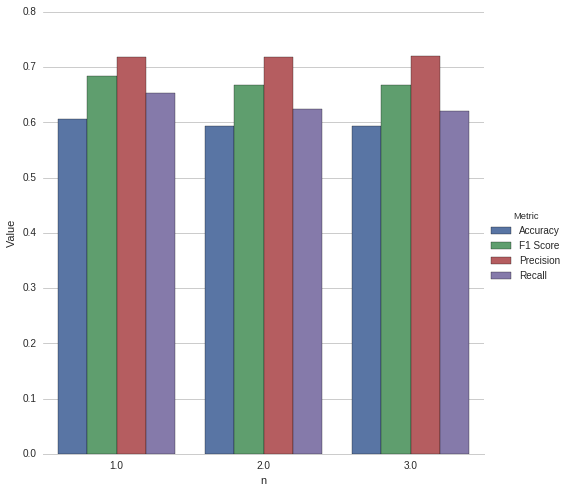

In [29]:
bar_chart_prep = pd.melt(ngram_eval_df, id_vars=['n'],
                         value_vars=['Accuracy', 'F1 Score', 'Precision', 'Recall'],
                         var_name='Metric', value_name='Value')

g = sns.factorplot(x='n', y='Value', hue='Metric', data=bar_chart_prep, size=7, kind='bar')
g.despine(left=True)
g.set_ylabels('Value')

### Sentiment development over time

In [61]:
class_df['total_sentiment'] = class_df['senti_pos'] + class_df['senti_neg']
class_df.head()

,content,cik,year,quarter,subsector,name,tic,SALES_value,OIADP,AT,...,OIADP_change,AT_change,CEQ_change,SALES_change,Subsector Name,senti_pos,senti_neg,pos_word_count,neg_word_count,total_sentiment
0,BEGIN PRIVACY ENHANCED MESSAGE Proc ...,891933.0,1998.0,1.0,NaN,None,None,0.875,pos,neg,...,11.00581248,-27.944530,221.3811421,-2.857142857,NaN,164.0,-249.0,15.0,-20.0,-85.0
1,Item Managements Discussion and Analysis ...,880643.0,2006.0,1.0,NaN,None,None,0.067,pos,pos,...,47.68094535,91.649018,-31.05743327,465.6716418,NaN,47.0,-59.0,6.0,-8.0,-12.0
2,Item Management s Discussion and Analysis of ...,1063665.0,2013.0,3.0,35101010.0,CORGENIX MEDICAL CORP,CONX,2.496,neg,pos,...,-146.2686567,3.660031,0.837053571,-4.126602564,Health Care Equipment,7.0,-22.0,1.0,-6.0,-15.0
3,ITEM MANAGEMENT S DISCUSSION AND ANALYSIS ...,887757.0,2001.0,2.0,NaN,None,None,14.835,neg,neg,...,-45.92178771,-6.520805,-9.097918273,-3.707448601,NaN,2.0,-26.0,0.0,-4.0,-24.0
4,ITEM MANAGEMENTS DISCUSSION AND ANAL...,1097136.0,2009.0,1.0,NaN,None,None,12.877,neg,pos,...,-108.4552846,0.031059,0.192527096,4.853614972,NaN,23.0,-51.0,6.0,-10.0,-28.0


In [62]:
senti_ts = class_df[['year', 'Subsector Name', 'total_sentiment']]
senti_ts['count'] = 1
senti_ts['year'] = senti_ts['year'] - 2009
senti_ts = senti_ts.groupby(['year', 'Subsector Name']).sum().reset_index()
senti_ts.head()

/home/stefan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/stefan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,year,Subsector Name,total_sentiment,count
0,0.0,Health Care Equipment,-187.0,2
1,0.0,Health Care Facilities,-70.0,1
2,0.0,Health Care Services,0.0,1
3,0.0,Health Care Technology,-8.0,2
4,0.0,Pharmaceuticals,-47.0,3


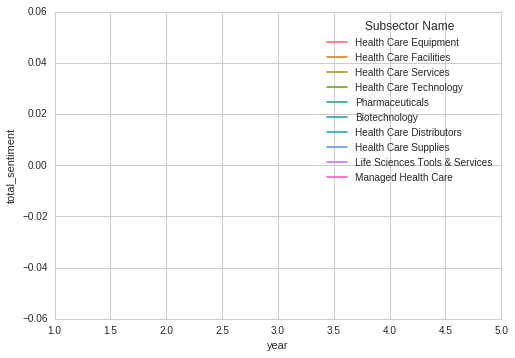

In [63]:
ax = sns.tsplot(time="year", value="total_sentiment", unit="count", condition="Subsector Name", data=senti_ts)

### Company Performance vs. Usage of Positive Words

/home/stefan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


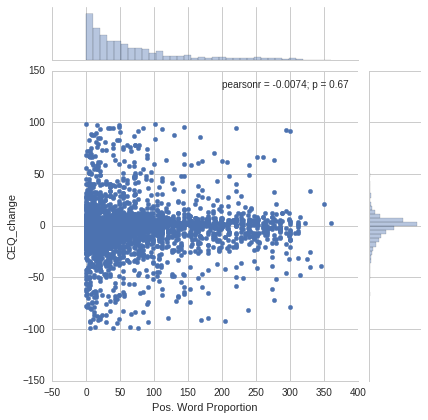

In [77]:
ceq_perf_df = class_df
ceq_perf_df['CEQ_change'] = ceq_perf_df['CEQ_change'].convert_objects(convert_numeric=True)
ceq_perf_df = ceq_perf_df[(ceq_perf_df['CEQ_change'] > -100.0) & (ceq_perf_df['CEQ_change'] < 100.0)]
ceq_perf_df = ceq_perf_df.replace([np.inf, -np.inf], np.nan)
ceq_perf_df['Pos. Word Proportion'] = ceq_perf_df['pos_word_count'] / (-1) * ceq_perf_df['neg_word_count']
ax = sns.jointplot(x='Pos. Word Proportion', y='CEQ_change', data=ceq_perf_df)